In [3]:
import re
import pandas as pd
import pickle
from yahoo_fin.stock_info import *
import numpy as np
import datetime
import itertools as it
import networkx as nx
import string
import seaborn as sns
import csv
import matplotlib.pyplot as plt
from collections import defaultdict
import nimfa
import scipy.io
import math


## Download historical stock data from the S&P 500

In the current version, I have downloaded weekly changes in stock price. I then sample one week per month for analysis.


In [11]:
def get_data(tickers):
    ##Input a list of tickers for desired stocks.
    ##Pulls weekly stock data from start_date to end_date for stocks listed consistently in the S&P500.
    ##Saves to individual csv files; removes missing stocks from the tickers list.
    
    missing=[]
    for ticker in tickers:
        try:
            df=get_data(str(ticker), interval = "1mo", start_date='02/01/1993', end_date='01/10/2020')
            df=df[['open', 'volume', 'ticker']]
            df.to_csv('../NMF_stocks/Data/stocks_'+str(ticker)+'.csv')
        except KeyError:
            missing.append(ticker)
            pass
        except AssertionError:
            missing.append(ticker)
            pass
    tickers_clean = [x for x in tickers if x not in missing]
    tickers_clean=pd.DataFrame(tickers_clean)
    return missing

def weekly_change(tickers):
    ##Creates variable with change in price from previous week; resaves to same individual csv file.
    
    for ticker in tickers:
        stock = '../NMF_stocks/Data/stocks_'+str(ticker)+'.csv'
        df = pd.read_csv(stock, header=0)
        #Create "Change" variable which records percentage change in stock price from previous week
        df['change'] = ((df.open - df.open.shift(1))/df.open.shift(1))*100
        df=df.set_index('date')
        df.to_csv('../NMF_stocks/Data/stocks_'+str(ticker)+'.csv', header=True, index=True, index_label='date')
        df.to_csv('../NMF_stocks/Data/stocks_'+str(ticker)+'.csv')

##Call functions
# tickers=pd.read_csv('../NMF_stocks/Data/tickers_clean.csv',header=None)
# tickers=tickers[2]
# get_data(tickers)
weekly_change(tickers)

## Create pair-wise matrices to record parallel changes in stock prices

In [13]:
def create_matrix(tickers):
    ##Creates a dataframe with each stock a column, each month a row, populated by the percent change in stock price.
    #Create datelist for indexing
    
    df=pd.read_csv('../NMF_stocks/Data/stocks_SPY.csv', header=0)
    dates= df['date']
    #Create df and populate through loop
    all_df= pd.DataFrame(index=dates, columns=tickers)
    for ticker in tickers:
        stock = '../NMF_stocks/Data/stocks_'+str(ticker)+'.csv'
        df = pd.read_csv(stock, header=0, index_col='date')
        for ind in df.index:
            all_df[ticker][ind] = df['change'][ind]
    all_df.to_csv('../NMF_stocks/Data/S&P500_price_change_matrix.csv', header=True, index=True)
    return all_df
            
def pair_wise(matrix, tickers):
    ##Creates a large matrix with differences in price changes between pair-wise combinations of stocks.
    for ind in matrix.index:
        df=pd.DataFrame(index=tickers, columns=tickers)
        for i, j in it.combinations(tickers, 2):
            df[i][j] = matrix[i][ind] - matrix[j][ind]
        date=matrix['date'][ind]
        title='../NMF_stocks/Data/pair_wise_' + str(date) + '.csv'
        df.to_csv(title, header=True)

##CALLING FUNCTIONS
create_matrix(tickers)
m1=pd.read_csv('../NMF_stocks/Data/S&P500_price_change_matrix.csv', header=0, index=True)
pair_wise(m1, tickers)


## Create network graphs of similar stocks, compute features, compile features matrices for each month

Here I create network graphs where nodes represent companies, and edges represent companies whose changes in stock price fell within 3% of each other month.  Weights are the proportion of days that month their prices tracked together. For simplicity, in the current version I have weighted edges by the proportion of weeks per month stock prices tracked together. In the future I plan to weight edges by proportion of days per month stock prices tracked together.

With each graph, I compute 6 network features for each stock.

v_vol is a feature indicating volatility, indicated by each stock's historical (monthly) standard deviation.
v_ind_avg is a feature which captures a stock's correlation with other stocks in its industry, indicated by number of edges the stock shares with other stocks within its industry divided by its total edges.
Finally, I compute betweenness centrality, weighted and unweighted clustering coefficient, and pagerank.

In future iterations I will remove the pagerank feature since it does not appear to be a significant part of any role.

In [880]:
def edge_weights(m, tickers):
    ## Creates a nested dictionary of weights for each possible edge. Weights range from 0 to 1, and
    ## indicate the proportion of weeks that month when the pair of stocks' weekly price changes were within 3% of 
    ## each other.
    
    edges_dict = defaultdict(dict)
    for i, j in it.combinations(tickers, 2):
        tup=str(i)+', '+str(j)
        for x in monthly:
            weight=0
            if abs(all_df[i][x]-all_df[j][x]) < 3:
                weight+=.25
            if abs(all_df[i][x-1]-all_df[j][x-1]) < 3:
                weight+=.25
            if abs(all_df[i][x-2]-all_df[j][x-2]) < 3:
                weight+=.25
            if abs(all_df[i][x-3]-all_df[j][x-3]) < 3:
                weight+=.25
            edges_dict[tup][x]=weight        
    f = open('../NMF_stocks/Data/edge_weight_dict.pkl',"wb")
    pickle.dump(edges_dict,f)
    f.close()
    
def features_matrix(date, month_index, edges_dict):     ## month_index is a list of multiples of 4 up to 1406
    ## Creates first a network graph where edges are added between stocks whose weekly price change is within 3% of
    ## each other.

    title='../NMF_stocks/Data/pair_wise_' + str(date) + '.csv'
    df=pd.read_csv(title, header=0)
    df.rename(columns={'Unnamed: 0': 'ticker'}, inplace=True)
    tickers=list(df['ticker'])
    df.set_index('ticker', inplace=True)
    G=nx.Graph()
    columns=tickers[:-1]
    for i in columns:
        ind=tickers.index(i)
        rows=tickers[ind:]
        for j in rows:
            if np.isnan(df[i][j]):
                continue
            if abs(df[i][j])<3:
                if i not in list(G.nodes):
                    industry = tickers_clean[3][i]
                    G.add_node(i, label=industry)
                if j not in list(G.nodes):
                    industry = tickers_clean[3][j]
                    G.add_node(j, label=industry)
                    ij=(i+', ' +j)
                G.add_edge(i, j, weight=edges_dict[ij][month_index])
    
    bwcent=nx.betweenness_centrality(G, weight='weight')
    wtdclustcoeff=nx.clustering(G, weight='weight')
    clustcoeff=nx.clustering(G)
    pgrank=nx.pagerank(G, weight='weight')
    
    features = {}
    all_df=pd.read_csv('../NMF_stocks/Data/S&P500_price_change_matrix.csv', header=0)
    std_dev=all_df.std(axis=0, skipna=True)
    means=all_df.mean(axis=0, skipna=True)
    for v in G.nodes():
        v_deg_industry=0
        v_deg=0
        v_ind_avg=0
        v_growth = mean[v]
        v_vol = std_dev[v]
        v_industry = G.nodes[v]['label']
        for w in G.nodes():
            w_industry=G.nodes[w]['label']
            if (v, w) in G.edges:
                v_deg+=1
                if v_industry == w_industry:
                    v_deg_industry+=1
            if (v, w) not in G.edges:
                continue
        if v_deg_industry==0:
            continue
        else:
            v_ind_avg=v_deg_industry / v_deg
        
        features[v] = [v_growth, v_vol, v_ind_avg, bwcent[v], wtdclustcoeff[v], clustcoeff[v], pgrank[v]]
    title='../NMF_stocks/Data/features_'+str(date)+'.pkl'
    f = open(title,"wb")
    pickle.dump(features,f)
    f.close()


In [881]:
##Calling function
# edge_weights(all_df, tickers)
# count=1
# for date in dates:    
#     index=month_index[count]
#     features_matrix(date, index, edges_dict)
#     count+=1
# pickle_off = open("edge_weight_dict.pkl","rb")
# edges_dict = pickle.load(pickle_off)
# print(edges_dict)

## Non-negative matrix factorization to calculate mean squared errors; iterate to find suitable rank

In [ ]:
## Do NMF on each month's features matrices and calculate mean squared errors on each to find suitable rank.

def nnmf(date):
    rmse = []
    kl_1 = []
    for r in range(1, 7):
        title='../NMF_stocks/Data/features_'+str(date)+'.pkl'
        infile = open(title,'rb')
        df = pickle.load(infile)
        infile.close()
        array = pd.DataFrame([([k] + v) for k, v in df.items()], columns=['ticker', 'growth', 'vol', 'industry', 'bwcent', 'wtdclustcoeff', 'clustcoeff', 'pgrank'])
        array=array.to_numpy()
        array_T=array.transpose()
        # Delete ticker column and growth column. (Growth can be negative; I included growth for later analytical purposes.)
        array_clean=np.delete(array_T, 0, axis=0)
        array_clean=np.delete(array_clean, 0, axis=0)
        nmf = nimfa.Nmf(array_clean, seed='nndsvd', max_iter=200, rank=r, update='euclidean', objective='fro')
        nmf_fit = nmf()
        #calculate root mean square error
        rmse += [nmf_fit.distance(metric='euclidean')/(math.sqrt(array_clean.shape[0]*array_clean.shape[1]))]
        kl_1 += [nmf_fit.distance(metric='kl')]
    rmse=pd.DataFrame(rmse)
    kl_1=pd.DataFrame(kl_1)
    title1='../NMF_stocks/Data/rmse'+str(date)+'.csv'
    rmse.to_csv(title1, header=None)
    title2='../NMF_stocks/Data/kl_1'+str(date)+'.csv'
    kl_1.to_csv(title2, header=None)        

In [97]:
for date in dates:
    nnmf(date)

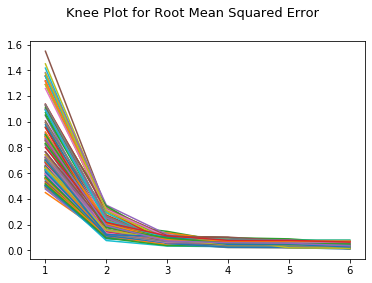

In [20]:
## Knee plots for RMSE show knee at rank 2 and 3.

month_index=pd.read_csv('../NMF_stocks/Data/basis_matrices_worked.csv', header=None)
month_index=month_index[1]

#Get dates
date_df=pd.read_csv('../NMF_stocks/Data/dates.csv',header=None)
dates=[]
for ind in month_index:
    new=date_df[1][ind]
    dates.append(new)
    
for date in dates:
    title='../NMF_stocks/Data/rmse'+str(date)+'.csv'
    rmse=pd.read_csv(title, header=None)
    plt.plot([1,2,3,4,5,6],rmse[1])
title='Knee Plot for Root Mean Squared Error'
plt.suptitle(title, fontsize=13, fontweight=0, color='black', y=1)
plt.savefig('../NMF_stocks/Plots/knee.png', fpi=300)
plt.show()


## NNMF with rank 3; save basis and coefficient matrices to csv

In [18]:
## Here I use rank 3 and save the basis and coefficient matrices for each decomposition of the features matrix.

def get_UV(dates):
    for date in dates:
        title='../NMF_stocks/Data/features_'+str(date)+'.pkl'
        infile = open(title,'rb')
        df = pickle.load(infile)
        infile.close()
        array = pd.DataFrame([([k] + v) for k, v in df.items()], columns=['ticker', 'vol', 'industry', 'bwcent', 'wtdclustcoeff', 'clustcoeff', 'pgrank'])
        array=array.to_numpy()
        array_T=array.transpose()
        # Delete ticker column and growth column. (Growth can be negative; I included growth for later analytical purposes.)
        array_clean=np.delete(array_T, 0, axis=0)
        array_clean=np.delete(array_clean, 0, axis=0)
        nmf = nimfa.Nmf(array_clean, seed='nndsvd', max_iter=200, rank=3, update='euclidean', objective='fro')
        nmf_fit = nmf()
        # Save the decomposed basis and coefficient matrices, U and V
        U = nmf_fit.basis()
        V = nmf_fit.coef()
        np.savetxt('../NMF_stocks/Data/U_'+str(date)+'.csv', U, delimiter=',')
        np.savetxt('../NMF_stocks/Data/V_'+str(date)+'.csv', V, delimiter=',')

## Call function
# get_UV(dates)

In [14]:
dates=pd.read_csv('../NMF_stocks/Data/dates.csv', header=None)
dates=dates[1]

## Using cosine similarity scores to match roles in basis matrices across distinct timestamps

Then, I use a matching algorithm to match these archetypes across networks represented at each timestamp.  These archetypes are roles, which are linear combinations of the network features.

However, not every iteration of the decomposition of the features matrix yields the same roles in the same order.  Therefore I match and reorder the columns of the basis matrices U(t) where t is the month's timestamp. I seek to find a one-to-one matching between the columns of the basis matrices and then determine whether the found matching is reliable or not.

Given two matrices U(t1) and U(t2), I first construct an r x r (here, r = rank 3) similarity matrix whose entry at the index (i; j) is defined as the cosine similarity between ith column of U(t1) and jth column of U(t2).

I then find the one-to-one matching with the maximum total similarity using a hand-coded version of the Hungarian algorithm.  A matching is considered reliable if the similarity between each pair of the matched columns has a similarity higher than 0.83.

In [82]:
def cosine_similarity(dates):
    for i in range(len(dates)-1):
        cos_sim=[]
        date1=dates[i]
        date2=dates[i+1]
        title1='../NMF_stocks/Data/U_'+str(date1)+'.csv'
        title2='../NMF_stocks/Data/U_'+str(date2)+'.csv'
        U1=pd.read_csv(title1, header=None)
        U2=pd.read_csv(title2, header=None)
        ## Cosine similarity score of 9 pair-wise combinations of 3 vectors with 3 vectors
        #First
        U1=np.array(U1)
        U1_=U1[:, 0]
        U2=np.array(U2)
        U2_=U2[:, 0]
        dot = np.dot(U1_, U2_)
        norm_U1 = np.linalg.norm(U1_)
        norm_U2 = np.linalg.norm(U2_)
        cos = dot / (norm_U1 * norm_U2)
        cos_sim.append(cos)
        #Second
        U1_=U1[:, 0]
        U2_=U2[:, 1]
        dot = np.dot(U1_, U2_)
        norm_U1 = np.linalg.norm(U1_)
        norm_U2 = np.linalg.norm(U2_)
        cos = dot / (norm_U1 * norm_U2)
        cos_sim.append(cos)
        #Third
        U1_=U1[:, 0]
        U2_=U2[:, 2]
        dot = np.dot(U1_, U2_)
        norm_U1 = np.linalg.norm(U1_)
        norm_U2 = np.linalg.norm(U2_)
        cos = dot / (norm_U1 * norm_U2)
        cos_sim.append(cos)
        #Fourth
        U1_=U1[:, 1]
        U2_=U2[:, 0]
        dot = np.dot(U1_, U2_)
        norm_U1 = np.linalg.norm(U1_)
        norm_U2 = np.linalg.norm(U2_)
        cos = dot / (norm_U1 * norm_U2)
        cos_sim.append(cos)
        #Fifth
        U1_=U1[:, 1]
        U2_=U2[:, 1]
        dot = np.dot(U1_, U2_)
        norm_U1 = np.linalg.norm(U1_)
        norm_U2 = np.linalg.norm(U2_)
        cos = dot / (norm_U1 * norm_U2)
        cos_sim.append(cos)
        #Sixth
        U1_=U1[:, 1]
        U2_=U2[:, 2]
        dot = np.dot(U1_, U2_)
        norm_U1 = np.linalg.norm(U1_)
        norm_U2 = np.linalg.norm(U2_)
        cos = dot / (norm_U1 * norm_U2)
        cos_sim.append(cos)
        #Seventh
        U1_=U1[:, 2]
        U2_=U2[:, 0]
        dot = np.dot(U1_, U2_)
        norm_U1 = np.linalg.norm(U1_)
        norm_U2 = np.linalg.norm(U2_)
        cos = dot / (norm_U1 * norm_U2)
        cos_sim.append(cos)
        #Eighth:
        U1_=U1[:, 2]
        U2_=U2[:, 1]
        dot = np.dot(U1_, U2_)
        norm_U1 = np.linalg.norm(U1_)
        norm_U2 = np.linalg.norm(U2_)
        cos = dot / (norm_U1 * norm_U2)
        cos_sim.append(cos)
        #Ninth:
        U1_=U1[:, 2]
        U2_=U2[:, 2]
        dot = np.dot(U1_, U2_)
        norm_U1 = np.linalg.norm(U1_)
        norm_U2 = np.linalg.norm(U2_)
        cos = dot / (norm_U1 * norm_U2)
        cos_sim.append(cos)
        title='../NMF_stocks/Data/cos_sim_'+str(date1)+'_'+str(date2)+'.csv'
        c=pd.DataFrame(cos_sim)
        c.to_csv(title, header=None)

def sorting(dates):
    basis_list=[]
    for i in range(len(dates)-1):
        date1=dates[i]
        date2=dates[i+1]
        title='../NMF_stocks/Data/cos_sim_'+str(date1)+'_'+str(date2)+'.csv'
        df=pd.read_csv(title, header=None)
        df=df[1]
        array=np.array(df).reshape(3,3)
        c=[]
        c1=array[0,1]+array[1,2]+array[2,0]
        c2=array[0,2]+array[1,0]+array[2,1]
        c3=array[0,1]+array[1,0]+array[2,2]
        c4=array[0,2]+array[1,1]+array[2,0]
        c5=array[0,0]+array[1,2]+array[2,1]
        c6=array[0,0]+array[1,1]+array[2,2]
        c.append(c1)
        c.append(c2)
        c.append(c3)
        c.append(c4)
        c.append(c5)
        c.append(c6)
        for j in range(1,6):
            if c[j]==max(c1, c2, c3, c4, c5, c6) and max(c1, c2, c3, c4, c5, c6)>2.5:
                basis_list.append(dates[i])
    basis=pd.DataFrame(basis_list)
    basis_list.to_csv('../NMF_stocks/Data/basis_list.csv', header=None)



In [179]:
# sorting(dates)
# reference_matrices(dates)

In [90]:
# fail=pd.read_csv('../NMF_stocks/Data/failed_basis_matrices.csv', header=None)
# fail=fail[1]
# fail=fail.tolist()
# new=[2, 3, 9, 11, 12, 13, 14]
# all_fail=fail+new
# worked=[]
# for i in range(351):
#     if i not in all_fail:
#         worked.append(i)
# worked1=pd.DataFrame(worked)
# worked1.to_csv('../NMF_stocks/Data/list_of_valid_basis_matrices.csv', header=None)

## Averaging a composite basis matrix, analyzing emergent roles

I look for five consecutive months where each column of the basis matrices have passed the cosine similarity test.
These five months will serve as a reference set.
I then move both forward and backward from this reference set, pairing reference matrices with matrices from adjacent months to find pairs that pass the cosine similarity test. When a pairing fails, I append this failed matrix to a 'fail' list and then continue.
In the end I should have a set of basis matrices with columns similar to each other. Then I average the columns of this set to find the archetypical roles.

In [120]:
def average_U(worked):
    ## Takes the average of all of the U features matrices which passed the cosine similarity score.

    u_00=[]
    u_01=[]
    u_02=[]
    u_10=[]
    u_11=[]
    u_12=[]
    u_20=[]
    u_21=[]
    u_22=[]
    u_30=[]
    u_31=[]
    u_32=[]
    u_40=[]
    u_41=[]
    u_42=[]
    u_50=[]
    u_51=[]
    u_52=[]
    for i in worked:
        date=dates[i]
        title='../NMF_stocks/Data/U_'+str(date)+'.csv'
        U=pd.read_csv(title, header=None)
        U=np.array(U)
        u_00.append(U[0,0])
        u_01.append(U[0,1])
        u_02.append(U[0,2])
        u_10.append(U[1,0])
        u_11.append(U[1,1])
        u_12.append(U[1,2])
        u_20.append(U[2,0])
        u_21.append(U[2,1])
        u_22.append(U[2,2])
        u_30.append(U[3,0])
        u_31.append(U[3,1])
        u_32.append(U[3,2])
        u_40.append(U[4,0])
        u_41.append(U[4,1])
        u_42.append(U[4,2])
        u_50.append(U[5,0])
        u_51.append(U[5,1])
        u_52.append(U[5,2])
        
    u_00_avg=sum(u_00) / len(u_00) 
    u_01_avg=sum(u_01) / len(u_01) 
    u_02_avg=sum(u_02) / len(u_02) 
    u_10_avg=sum(u_10) / len(u_10)
    u_11_avg=sum(u_11) / len(u_11)
    u_12_avg=sum(u_12) / len(u_12) 
    u_20_avg=sum(u_20) / len(u_20) 
    u_21_avg=sum(u_21) / len(u_21) 
    u_22_avg=sum(u_22) / len(u_22)
    u_30_avg=sum(u_30) / len(u_30)
    u_31_avg=sum(u_31) / len(u_31)
    u_32_avg=sum(u_32) / len(u_32)
    u_40_avg=sum(u_40) / len(u_40)
    u_41_avg=sum(u_41) / len(u_41)
    u_42_avg=sum(u_42) / len(u_42)
    u_50_avg=sum(u_50) / len(u_50)
    u_51_avg=sum(u_51) / len(u_51)
    u_52_avg=sum(u_52) / len(u_52)
    
    composite_features=[u_00_avg, u_01_avg, u_02_avg, u_10_avg, u_11_avg, u_12_avg, u_20_avg, u_21_avg, u_22_avg, u_30_avg, u_31_avg, u_32_avg, u_40_avg, u_41_avg, u_42_avg, u_50_avg, u_51_avg, u_52_avg]
    composite_features=pd.DataFrame(composite_features)
    composite_features.to_csv('../NMF_stocks/Data/composite_features.csv', header=None)


In [121]:
def reference_matrices(dates):

    i=15
    j=16
    count=0
    fail=[]
    while i<351 and j<351:
        cos_sim=[]
        date1=dates[i]
        date2=dates[j]
        title1='../NMF_stocks/Data/U_'+str(date1)+'.csv'
        title2='../NMF_stocks/Data/U_'+str(date2)+'.csv'
        U1=pd.read_csv(title1, header=None)
        U2=pd.read_csv(title2, header=None)
        #First
        U1=np.array(U1)
        U1_=U1[:, 0]
        U2=np.array(U2)
        U2_=U2[:, 0]
        dot = np.dot(U1_, U2_)
        norm_U1 = np.linalg.norm(U1_)
        norm_U2 = np.linalg.norm(U2_)
        cos = dot / (norm_U1 * norm_U2)
        cos_sim.append(cos)
        #Second
        U1_=U1[:, 0]
        U2_=U2[:, 1]
        dot = np.dot(U1_, U2_)
        norm_U1 = np.linalg.norm(U1_)
        norm_U2 = np.linalg.norm(U2_)
        cos = dot / (norm_U1 * norm_U2)
        cos_sim.append(cos)
        #Third
        U1_=U1[:, 0]
        U2_=U2[:, 2]
        dot = np.dot(U1_, U2_)
        norm_U1 = np.linalg.norm(U1_)
        norm_U2 = np.linalg.norm(U2_)
        cos = dot / (norm_U1 * norm_U2)
        cos_sim.append(cos)
        #Fourth
        U1_=U1[:, 1]
        U2_=U2[:, 0]
        dot = np.dot(U1_, U2_)
        norm_U1 = np.linalg.norm(U1_)
        norm_U2 = np.linalg.norm(U2_)
        cos = dot / (norm_U1 * norm_U2)
        cos_sim.append(cos)
        #Fifth
        U1_=U1[:, 1]
        U2_=U2[:, 1]
        dot = np.dot(U1_, U2_)
        norm_U1 = np.linalg.norm(U1_)
        norm_U2 = np.linalg.norm(U2_)
        cos = dot / (norm_U1 * norm_U2)
        cos_sim.append(cos)
        #Sixth
        U1_=U1[:, 1]
        U2_=U2[:, 2]
        dot = np.dot(U1_, U2_)
        norm_U1 = np.linalg.norm(U1_)
        norm_U2 = np.linalg.norm(U2_)
        cos = dot / (norm_U1 * norm_U2)
        cos_sim.append(cos)
        #Seventh
        U1_=U1[:, 2]
        U2_=U2[:, 0]
        dot = np.dot(U1_, U2_)
        norm_U1 = np.linalg.norm(U1_)
        norm_U2 = np.linalg.norm(U2_)
        cos = dot / (norm_U1 * norm_U2)
        cos_sim.append(cos)
        #Eighth:
        U1_=U1[:, 2]
        U2_=U2[:, 1]
        dot = np.dot(U1_, U2_)
        norm_U1 = np.linalg.norm(U1_)
        norm_U2 = np.linalg.norm(U2_)
        cos = dot / (norm_U1 * norm_U2)
        cos_sim.append(cos)
        #Ninth:
        U1_=U1[:, 2]
        U2_=U2[:, 2]
        dot = np.dot(U1_, U2_)
        norm_U1 = np.linalg.norm(U1_)
        norm_U2 = np.linalg.norm(U2_)
        cos = dot / (norm_U1 * norm_U2)
        cos_sim.append(cos)
        ##
        array=np.array(cos_sim).reshape(3,3)
        c1=array[0,1]+array[1,2]+array[2,0]
        c2=array[0,2]+array[1,0]+array[2,1]
        c3=array[0,1]+array[1,0]+array[2,2]
        c4=array[0,2]+array[1,1]+array[2,0]
        c5=array[0,0]+array[1,2]+array[2,1]
        c6=array[0,0]+array[1,1]+array[2,2]
        if max(c1, c2, c3, c4, c5, c6)>2.5:
            print('Cosine similarity between {} and {} basis matrices worked.'.format(i, j))
            i+=1
            j+=1
            if count>0:
                i+=count
                count=0
            else:
                continue
        else:
            fail.append(j)
            print('Cosine similarity between {} and {} basis matrices failed.'.format(i, j))
            j+=1
            count+=1
    fail=pd.DataFrame(fail)
    fail.to_csv('../NMF_stocks/Data/failed_basis_matrices.csv', header=None)

# average_U(worked)

## Now we're ready to plot and interpret the three archetypical stock roles:

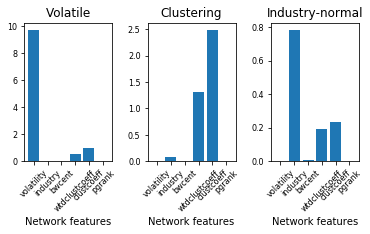

In [4]:
def plot_archetypes(composite_basis_matrix):  
    #Input composite_basis_matrix, a k x r matrix, where k is the number of
    #features input into nmf and r is the rank of the nmf.
    #Plots the three role archetypes as linear combination of features.

    fig=plt.figure()

    ## Role 1
    ax1=plt.subplot(131)
    
    ax1.tick_params(axis='both', which='major', labelsize=8)
    ax1.tick_params(axis='both', which='minor', labelsize=6)
    dataset = pd.DataFrame({'Feature1': features[:, 0], 'Feature2': features[:, 1], 'Feature3': features[:, 2]})
    y_pos=np.arange(np.size(features,0))
    bars=('volatility', 'industry', 'bwcent', 'wtdclustcoeff', 'clustcoeff', 'pgrank')
    feature1=dataset['Feature1']
    feature1=list(feature1)
    plt.bar(y_pos, feature1)
    plt.xticks(y_pos, bars, rotation='45')
    plt.title('Volatile')
    plt.xlabel('Network features')
    
    ## Role 2
    ax2=plt.subplot(132)
 
    ax2.tick_params(axis='both', which='major', labelsize=8)
    ax2.tick_params(axis='both', which='minor', labelsize=6)
    dataset = pd.DataFrame({'Feature1': features[:, 0], 'Feature2': features[:, 1], 'Feature3': features[:, 2]})
    y_pos=np.arange(np.size(features,0))
    bars=('volatility', 'industry', 'bwcent', 'wtdclustcoeff', 'clustcoeff', 'pgrank')
    feature1=dataset['Feature2']
    feature1=list(feature1)
    plt.bar(y_pos, feature1)
    plt.xticks(y_pos, bars, rotation='45')
    plt.title('Clustering')
    plt.xlabel('Network features')
    
    # Role 3
    ax3=plt.subplot(133)

    ax3.tick_params(axis='both', which='major', labelsize=8)
    ax3.tick_params(axis='both', which='minor', labelsize=6)
    dataset = pd.DataFrame({'Feature1': features[:, 0], 'Feature2': features[:, 1], 'Feature3': features[:, 2]})
    y_pos=np.arange(np.size(features,0))
    bars=('volatility', 'industry', 'bwcent', 'wtdclustcoeff', 'clustcoeff', 'pgrank')
    feature1=dataset['Feature3']
    feature1=list(feature1)
    plt.bar(y_pos, feature1)
    plt.xticks(y_pos, bars, rotation='45')
    plt.title('Industry-normal')
    plt.xlabel('Network features')

    fig.subplots_adjust(wspace=.4, bottom=.4)
    plt.savefig('../NMF_stocks/Plots/feature_archetypes.jpg', dpi=300)

##Upload composite basis matrix
features=pd.read_csv('../NMF_stocks/Data/composite_features.csv', header=None)
features=features[1]
features=np.array(features)
features=np.reshape(features, (6,3))
##Call function
plot_archetypes(features)

## The Volatile role:
These stocks tend to fluctuate widely in price.  Price changes do not track consistently with industry averages.  High-volatility stocks should be paired with low-volatile stocks in a portfolio.

## The Clustering role:
These stocks move consistently in tandem with a set of other stocks, although not necessarily others within its industry.  In future analysis I will examine how coherent these clusters appear across time.  Stocks that cluster together consistently over the long-term should not be paired together in a portfolio.

## The Industry-normal role:
These stocks' prices tend to move in tandem with industry averages. In future analysis I will examine which stocks tend to track with industry averages over the long term. No portfolio should contain two stocks that track closely with the same industry over the long-term.